In [1]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.model_selection import cross_val_score, cross_val_predict

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3

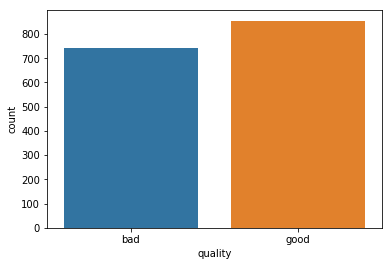

In [2]:
# load data
df = pd.read_csv('https://gitlab.com/yuxuan.chen/storage/'\
    '-/raw/master/MLDS-2019/week6/winequality-red.csv')
print(df.head())

# aggregate the numerical 'quality' into two classes
# here we use the threshold=5
# the new partition of quality replaces the older
bins = (2, 5, 8)
group_names = ['bad', 'good']
df['quality'] = pd.cut(x=df['quality'], 
                       bins = bins, 
                       labels = group_names)
sns.countplot(df['quality'])

In [3]:
# re-encode categorical columns with numerics
df['quality'] = LabelEncoder().fit_transform(df['quality'])
print(df['quality'].value_counts())

1    855
0    744
Name: quality, dtype: int64


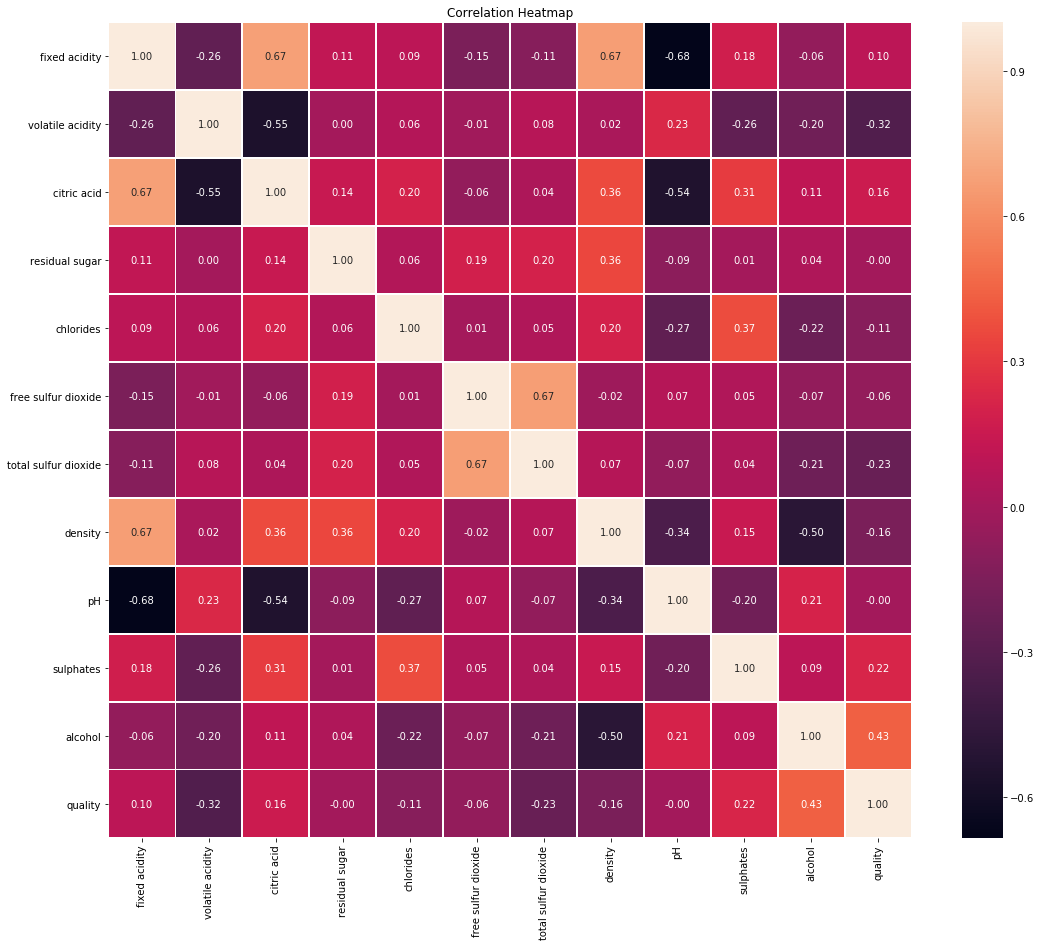

In [4]:
# correlation heatmap
f,ax=plt.subplots(figsize = (18,15))
sns.heatmap(data=df.corr(), 
            annot=True, 
            linewidths=0.5, 
            fmt = '.2f', 
            ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Heatmap')
plt.show()

In [5]:
X, y = df.drop('quality', axis=1), df['quality']

In [6]:
def conclude_cm(cm):
    print('confusion matrix:\n', cm)

    [tp, fn], [fp, tn] = cm
    accuracy = (tp + tn) / (tp + fn + fp + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * precision * recall / (precision + recall)

    print('accuracy: %0.3f' % accuracy)
    print('precision: %0.3f' % precision)
    print('recall(aka sensitivity): %0.3f' % recall)
    print('specificity: %0.3f' % specificity)
    print('f1 score: %0.3f' % f1_score)

In [7]:
# naive bayes with 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 17)

start_time = time.time()
nb = GaussianNB().fit(X_train, y_train)
pred = nb.predict(X_test)
end_time = time.time()

pred_proba = nb.predict_proba(X_test)[:, 1]
fpr_1, tpr_1, _ = roc_curve(y_test,  pred_proba)
auc_1 = roc_auc_score(y_test, pred_proba)

cm = confusion_matrix(y_test, pred)
conclude_cm(cm)

run_time = end_time - start_time
print('running time: %s seconds' % run_time)

confusion matrix:
 [[170  52]
 [ 61 197]]
accuracy: 0.765
precision: 0.736
recall(aka sensitivity): 0.766
specificity: 0.764
f1 score: 0.751
running time: 0.0019941329956054688 seconds


In [8]:
# reduce columns based on correlation
# remove "pH" and "fixed acidity"
X_train = X_train.drop(columns=['pH', 'fixed acidity'])
X_test = X_test.drop(columns=['pH', 'fixed acidity'])

nb = GaussianNB().fit(X_train, y_train)
pred = nb.predict(X_test)

pred_proba = nb.predict_proba(X_test)[:, 1]
fpr_3, tpr_3, _ = roc_curve(y_test,  pred_proba)
auc_3 = roc_auc_score(y_test, pred_proba)

cm = confusion_matrix(y_test, pred)
conclude_cm(cm)

confusion matrix:
 [[174  48]
 [ 55 203]]
accuracy: 0.785
precision: 0.760
recall(aka sensitivity): 0.784
specificity: 0.787
f1 score: 0.772


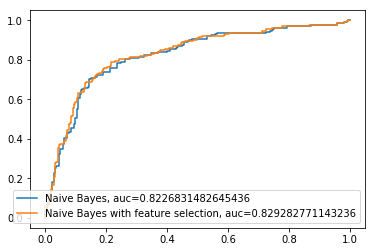

In [9]:
plt.plot(fpr_1, tpr_1, 
         label='Naive Bayes, auc=' + str(auc_1))
plt.plot(fpr_3, tpr_3, 
         label='Naive Bayes with feature selection, auc=' + str(auc_3))
plt.legend(loc=4)
plt.show()

In [10]:
# naive bayes with 5-fold cross-validation
start_time = time.time()
nb = GaussianNB()
pred = cross_val_predict(nb, X, y, cv=5)
end_time = time.time()

cm = confusion_matrix(y, pred)
conclude_cm(cm)

run_time = end_time - start_time
print('running time: %s seconds' % run_time)

confusion matrix:
 [[524 220]
 [232 623]]
accuracy: 0.717
precision: 0.693
recall(aka sensitivity): 0.704
specificity: 0.729
f1 score: 0.699
running time: 0.02355480194091797 seconds


In [11]:
# naive bayes with leave-one-out cross-validation
start_time = time.time()
nb = GaussianNB()
pred = cross_val_predict(nb, X, y, cv=LeaveOneOut().split(X))
end_time = time.time()

cm = confusion_matrix(y, pred)
conclude_cm(cm)

run_time = end_time - start_time
print('running time: %s seconds' % run_time)

confusion matrix:
 [[529 215]
 [227 628]]
accuracy: 0.724
precision: 0.700
recall(aka sensitivity): 0.711
specificity: 0.735
f1 score: 0.705
running time: 5.3250486850738525 seconds


In [12]:
# knn with 70-30
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 17)
    
for k in range(1, 9):
    start_time = time.time()
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred_knn = knn.predict(X_test)
    end_time = time.time()

    print('=' * 50, '\nk=', k, ':')
    cm = confusion_matrix(y_test, pred_knn)
    conclude_cm(cm)

    run_time = end_time - start_time
    print('running time: %s seconds' % run_time)

k= 1 :
confusion matrix:
 [[153  69]
 [ 68 190]]
accuracy: 0.715
precision: 0.692
recall(aka sensitivity): 0.689
specificity: 0.736
f1 score: 0.691
running time: 0.01595592498779297 seconds
k= 2 :
confusion matrix:
 [[194  28]
 [133 125]]
accuracy: 0.665
precision: 0.593
recall(aka sensitivity): 0.874
specificity: 0.484
f1 score: 0.707
running time: 0.019610881805419922 seconds
k= 3 :
confusion matrix:
 [[158  64]
 [ 97 161]]
accuracy: 0.665
precision: 0.620
recall(aka sensitivity): 0.712
specificity: 0.624
f1 score: 0.662
running time: 0.017678260803222656 seconds
k= 4 :
confusion matrix:
 [[173  49]
 [127 131]]
accuracy: 0.633
precision: 0.577
recall(aka sensitivity): 0.779
specificity: 0.508
f1 score: 0.663
running time: 0.019585132598876953 seconds
k= 5 :
confusion matrix:
 [[145  77]
 [102 156]]
accuracy: 0.627
precision: 0.587
recall(aka sensitivity): 0.653
specificity: 0.605
f1 score: 0.618
running time: 0.024169921875 seconds
k= 6 :
confusion matrix:
 [[159  63]
 [121 137]]
acc

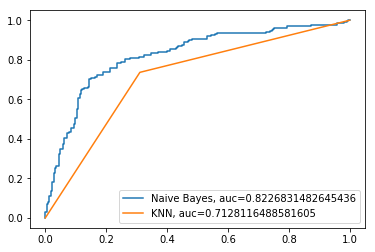

In [13]:
# plot roc graph with the best k
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

pred_proba = knn.predict_proba(X_test)[:, 1]
fpr_2, tpr_2, _ = roc_curve(y_test,  pred_proba)
auc_2 = roc_auc_score(y_test, pred_proba)

plt.plot(fpr_1, tpr_1, 
         label='Naive Bayes, auc=' + str(auc_1))
plt.plot(fpr_2, tpr_2, 
         label='KNN, auc=' + str(auc_2))
plt.legend(loc=4)
plt.show()

In [14]:
# knn with 5-fold cross-validation
start_time = time.time()
knn = KNeighborsClassifier()
pred = cross_val_predict(knn, X, y, cv=5)
end_time = time.time()

cm = confusion_matrix(y, pred)
conclude_cm(cm)

run_time = end_time - start_time
print('running time: %s seconds' % run_time)

confusion matrix:
 [[407 337]
 [315 540]]
accuracy: 0.592
precision: 0.564
recall(aka sensitivity): 0.547
specificity: 0.632
f1 score: 0.555
running time: 0.09154558181762695 seconds


In [15]:
# knn with leave-one-out cross-validation
start_time = time.time()
knn = KNeighborsClassifier()
pred = cross_val_predict(knn, X, y, cv=LeaveOneOut().split(X))
end_time = time.time()

cm = confusion_matrix(y, pred)
conclude_cm(cm)

run_time = end_time - start_time
print('running time: %s seconds' % run_time)

confusion matrix:
 [[473 271]
 [272 583]]
accuracy: 0.660
precision: 0.635
recall(aka sensitivity): 0.636
specificity: 0.682
f1 score: 0.635
running time: 6.335018873214722 seconds


In [17]:
# add noise
# 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 17)

dim = X_train.shape

for mu in [0.1, 0.2]:
    print('\nnoise level:', mu)
    noise = np.random.normal(scale=mu, size=dim)
    X_train = X_train + noise

    nb = GaussianNB()
    nb.fit(X_train, y_train)
    pred = nb.predict(X_test)
    cm = confusion_matrix(y_test, pred)   
    conclude_cm(cm)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    conclude_cm(cm)


noise level: 0.1
confusion matrix:
 [[180  42]
 [ 70 188]]
accuracy: 0.767
precision: 0.720
recall(aka sensitivity): 0.811
specificity: 0.729
f1 score: 0.763
confusion matrix:
 [[155  67]
 [ 67 191]]
accuracy: 0.721
precision: 0.698
recall(aka sensitivity): 0.698
specificity: 0.740
f1 score: 0.698

noise level: 0.2
confusion matrix:
 [[177  45]
 [ 73 185]]
accuracy: 0.754
precision: 0.708
recall(aka sensitivity): 0.797
specificity: 0.717
f1 score: 0.750
confusion matrix:
 [[154  68]
 [ 75 183]]
accuracy: 0.702
precision: 0.672
recall(aka sensitivity): 0.694
specificity: 0.709
f1 score: 0.683
